In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import os



In [ ]:
import os
import zipfile


zip_path = '/content/drive/My Drive/dog-breed-identification.zip'


extract_path = '/content/dog_breed_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)



Dataset extracted to: /content/dog_breed_data


In [ ]:
print("Files in dataset directory:")
print(os.listdir(extract_path))


Files in dataset directory:
['test', 'labels.csv', 'train', 'sample_submission.csv']


In [ ]:
labels_path = '/content/dog_breed_data/labels.csv'
labels_df = pd.read_csv(labels_path)


label_encoder = LabelEncoder()
labels_df['breed_encoded'] = label_encoder.fit_transform(labels_df['breed'])

labels_df['breed_str'] = labels_df['breed']


train_dir = '/content/dog_breed_data/train'
labels_df['path'] = labels_df['id'].apply(lambda x: os.path.join(train_dir, f"{x}.jpg"))


In [ ]:
train_df, val_df = train_test_split(
    labels_df,
    test_size=0.2,
    stratify=labels_df['breed_encoded'],
    random_state=42
)

print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")


Training samples: 8177, Validation samples: 2045


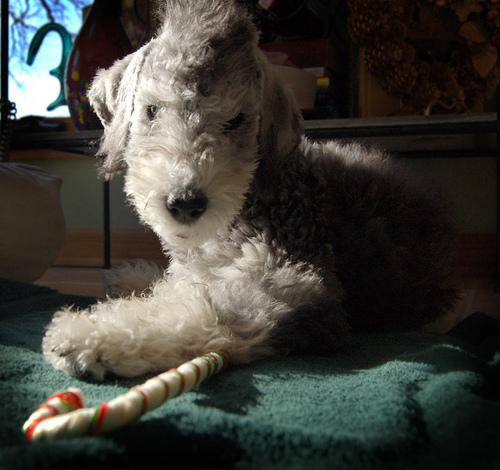

In [ ]:
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
image = cv2.imread('/content/dog_breed_data/train/00290d3e1fdd27226ba27a8ce248ce85.jpg', cv2.IMREAD_COLOR)
cv2_imshow(image)




(-0.5, 499.5, 469.5, -0.5)

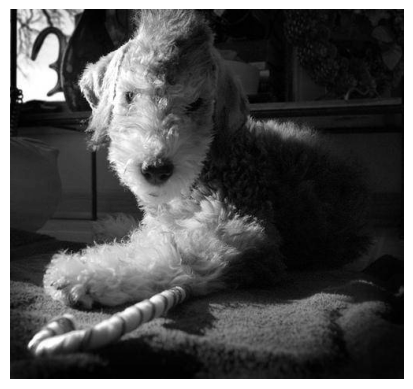

In [ ]:
norm =cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F)

plt.imshow(norm,cmap='gray')
plt.axis('off')


In [ ]:
image_size = (224, 224)
batch_size = 32
num_classes = len(label_encoder.classes_)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='breed_str',
    target_size=image_size,
    class_mode='categorical',
    batch_size=batch_size
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='breed_str',
    target_size=image_size,
    class_mode='categorical',
    batch_size=batch_size
)

Found 8177 validated image filenames belonging to 120 classes.
Found 2045 validated image filenames belonging to 120 classes.


In [ ]:

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


base_model.trainable = False


model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 120)                 │         153,720 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,203,291 (16.03 MB)

 Trainable params: 153,720 (600.47 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
base_model.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    steps_per_epoch=train_generator.n // batch_size,
    validation_steps=val_generator.n // batch_size
)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


255/255 ━━━━━━━━━━━━━━━━━━━━ 2809s 11s/step - accuracy: 0.0096 - loss: 4.9018 - val_accuracy: 0.0079 - val_loss: 4.7901
Epoch 2/5
  1/255 ━━━━━━━━━━━━━━━━━━━━ 43:12 10s/step - accuracy: 0.0000e+00 - loss: 4.8226

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


255/255 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.0000e+00 - loss: 4.8226 - val_accuracy: 0.0000e+00 - val_loss: 4.7786
Epoch 3/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 2697s 11s/step - accuracy: 0.0146 - loss: 4.8046 - val_accuracy: 0.0089 - val_loss: 4.8089
Epoch 4/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.0312 - loss: 4.7221 - val_accuracy: 0.0000e+00 - val_loss: 4.8278
Epoch 5/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 2671s 10s/step - accuracy: 0.0224 - loss: 4.7095 - val_accuracy: 0.0441 - val_loss: 4.6181


In [ ]:
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


In [ ]:
## task 4


initial_learning_rate = 0.001

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True
)


optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)


checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True
)


In [ ]:
# Training
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping, checkpoint]
)


In [ ]:

model.load_weights("best_model.h5")


test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Best Test Accuracy: {test_accuracy:.4f}")
print(f"Best Test Loss: {test_loss:.4f}")


In [ ]:
#week 4 regularization
from tensorflow.keras.regularizers import l2

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation="softmax",
          kernel_regularizer=l2(0.01))
])
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)


In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping],
)


In [ ]:
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


In [ ]:
#5th task
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


def compute_gradcam(model, image, layer_name, class_idx):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    weights = tf.reduce_mean(grads, axis=(1, 2))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1).numpy()
    cam = np.maximum(cam, 0)
    cam = cam[0]
    cam = (cam - cam.min()) / (cam.max() - cam.min())
    return cam

# Function to overlay Grad-CAM on the image
def overlay_gradcam(image, cam, alpha=0.4):
    cam = tf.image.resize(cam, (image.shape[1], image.shape[2]))
    heatmap = plt.cm.jet(cam.numpy())[:, :, :3]
    overlay = (1 - alpha) * image + alpha * heatmap
    return np.clip(overlay, 0, 1)


img = next(iter(validation_dataset.take(1)))[0]
img = tf.expand_dims(img, axis=0)


predicted_class = tf.argmax(model.predict(img), axis=1)[0]
cam = compute_gradcam(model, img, "top_conv", predicted_class)


overlay = overlay_gradcam(img[0].numpy(), cam)
plt.imshow(overlay)
plt.axis('off')
plt.show()


In [ ]:

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


base_model.trainable = False


model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

In [ ]:
##actual pruning
from tensorflow_model_optimization.sparsity.keras import prune_low_magnitude, PolynomialDecay
pruning_schedule = PolynomialDecay(
    initial_sparsity=0.0,
    final_sparsity=0.5,
    begin_step=2000,
    end_step=10000
)

pruned_model = tf.keras.models.clone_model(
    model,
    clone_function=lambda layer: prune_low_magnitude(layer, pruning_schedule)
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.Dense)
    else layer,
)


In [ ]:

pruned_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

pruned_model.fit(train_dataset, validation_data=validation_dataset, epochs=5)


In [ ]:
from tensorflow_model_optimization.sparsity.keras import strip_pruning
final_model = strip_pruning(pruned_model)
final_model.save("production_ready_model")
